# Lab2 (5IR - 2024): Fall Detection - Supervised learning

**Group name (2 people !):** A2

**Names:** BOUZERGAN & HOUSNI

**First names:** Kenza & Lamiaa


**Introduction :**

In this lab, our main objectives were to develop a fall detection system using artificial neural networks, with a focus on convolutional neural networks (CNNs). We will use TensorFlow, a powerful deep learning framework, to create an efficient CNN architecture for the fall detection dataset CAUCA. The lab involved studying the architecture of neural networks, exploring the sensitivity of key parameters, and leveraging TensorFlow Lite to compress the CNN, making it suitable for deployment on resource-constrained devices. 

In [9]:
!pip install tensorflow_model_optimization

  Using cached tensorflow_model_optimization-0.7.5-py2.py3-none-any.whl.metadata (914 bytes)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.4/115.4 kB 850.5 kB/s eta 0:00:0000:0100:01
Using cached tensorflow_model_optimization-0.7.5-py2.py3-none-any.whl (241 kB)


In [1]:
from six.moves import cPickle as pickle
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
import seaborn as sns
import numpy as np
import tempfile
import os
import zipfile
import math
# Scikit-learn
from sklearn.metrics import accuracy_score, confusion_matrix
# TensorFlow
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, save_model, clone_model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.saving import load_model
from sklearn.model_selection import train_test_split
# TensorFlow Optimization
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.sparsity.keras import prune_low_magnitude, PolynomialDecay, UpdatePruningStep, ConstantSparsity

2024-01-29 18:38:27.380505: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 1. Classification of the CAUCA dataset using Convolutional Neural Netowrks (CNN)

TensorFlow is an open-source machine learning library developed by Google, primarily used for deep learning applications. It provides a comprehensive, flexible ecosystem of tools, libraries, and community resources that enables researchers to develop and deploy machine learning powered applications easily. We use the Python version of the library which can be installed in Python with:
*pip install tensorflow*

We will use the library **tensorflow.keras** to develop ANN of type Convolutional Neural Netowrks (CNN). We use the generic class **Sequential** combined with layers of types:
- **Conv2D**,
- **MaxPooling2D**,
- **BatchNormalization**,
- **Dropout**,
- **Flatten**,
- **Dense**.

<img src="https://miro.medium.com/v2/resize:fit:1400/1*uAeANQIOQPqWZnnuH-VEyw.jpeg" alt="CNN example" />

The documentation for the Tensorflow layers is available at https://www.tensorflow.org/api_docs/python/tf/keras/layers.
Since an example is better than 1000 words, below is a fully working example code for a toy classification problem.

## 1.1 Hand-drawn shapes (HDS) dataset

Some datasets are available on the internet (search Google, Kaggle, and scientific articles). Here, we focus on a small example dataset extracted from the repository: https://github.com/frobertpixto/hand-drawn-shapes-dataset/tree/main. This dataset contains 70x70px images (in .png format) in grayscale of hand-drawn shapes. The images can be of 4 classes: ellipse, triangle, rectangle, others. There are around 50 000 images available. Processing codes are available on github to preprocess the pictures, and build a CNN model for classification.

<img src="https://raw.githubusercontent.com/frobertpixto/hand-drawn-shapes-dataset/main/readme_images/train_images.png" alt="HDS example" />

We have modified the processing code from the repository in order to reduce the dataset for our purpose:
- The images are resized to 14x14px,
- We only keep the classes ellipse, triangle, and rectangle,
- We keep 4 500 images.

The dataset is stored in a pickle file which allows to drop Python data structures to a binary file. The structure is a dictionnary with the data X at key "train_data", and the labes y at key "train_labels":
- Storing:
*save_to_pickle(*
    *"train.pickle",*
    *{*
        *'train_data': train_data,*
        *'train_labels': train_labels*
    *}*
*)*
- Loading
*with open("train.pickle", 'rb') as file:*
    *train_dict = pickle.load(file)*

- Load data
- N.B.: In the obtained labels y, class 1="ellipse", class 2="rectangle", class 3="triangle"

In [2]:
with open("hds_data.pickle", 'rb') as file:
    train_dict = pickle.load(file)
X = train_dict['train_data']
y = train_dict['train_labels'] - 1

Image:  1577


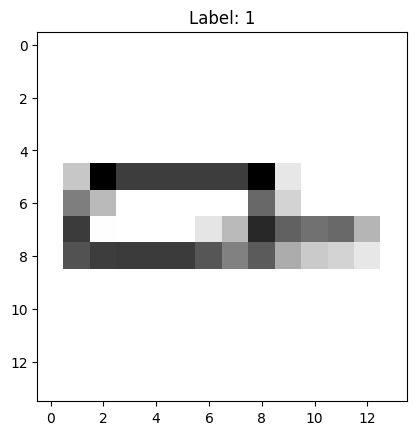

In [3]:
ind = random.randint(0, len(X))
print("Image: ",ind)
plt.imshow(X[ind],cmap=plt.cm.gray_r,interpolation="nearest")
plt.title(f"Label: {y[ind]}")
plt.show()

- **Split into train and test datasets**

In [4]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y, train_size=0.8)

# Reshape and normalize the images
xtrain = xtrain.reshape((xtrain.shape[0], 14, 14, 1)).astype('float32')
xtest = xtest.reshape((xtest.shape[0], 14, 14, 1)).astype('float32')

# Convert labels to categorical (one-hot encoding)
ytrain = to_categorical(ytrain)
ytest = to_categorical(ytest)

- **Create the model**

In [5]:
# Building the CNN model
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(14, 14, 1)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 12, 12, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 12, 12, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 6, 6, 32)         0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 1152)              0         
                                                                 
 dense (Dense)               (None, 32)                36896     
                                                                 
 dense_1 (Dense)             (None, 3)                 9

- **Compile and train the model**

In [6]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(xtrain, ytrain, validation_data=(xtest, ytest), epochs=10, batch_size=128)

Epoch 1/10
29/29 [==============================] - 1s 18ms/step - loss: 0.7667 - accuracy: 0.6628 - val_loss: 1.0415 - val_accuracy: 0.5022
Epoch 2/10
29/29 [==============================] - 0s 13ms/step - loss: 0.4937 - accuracy: 0.8033 - val_loss: 1.0112 - val_accuracy: 0.5089
Epoch 3/10
29/29 [==============================] - 0s 15ms/step - loss: 0.3981 - accuracy: 0.8511 - val_loss: 0.9727 - val_accuracy: 0.5267
Epoch 4/10
29/29 [==============================] - 0s 17ms/step - loss: 0.3370 - accuracy: 0.8711 - val_loss: 0.9316 - val_accuracy: 0.5533
Epoch 5/10
29/29 [==============================] - 0s 13ms/step - loss: 0.2857 - accuracy: 0.8997 - val_loss: 0.9007 - val_accuracy: 0.5756
Epoch 6/10
29/29 [==============================] - 0s 15ms/step - loss: 0.2581 - accuracy: 0.9111 - val_loss: 0.8605 - val_accuracy: 0.5478
Epoch 7/10
29/29 [==============================] - 0s 15ms/step - loss: 0.2249 - accuracy: 0.9175 - val_loss: 0.8068 - val_accuracy: 0.6200
Epoch 8/10
29

- **TODO: Evaluate the model** (this will help you later):
    - display a random image in the test set with its true and predicted labels,
    - display the accuracy of the CNN on the train and test sets,
    - compute and display the confusion matrix of the model,
    - display the evolution of the accuracy over the training iterations of the CNN.

29/29 [==============================] - 0s 2ms/step


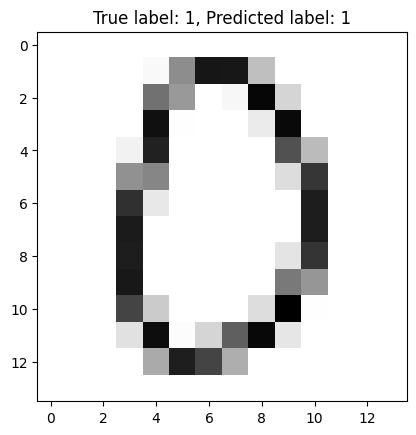

Train Accuracy: 0.7644
Test Accuracy: 0.7167


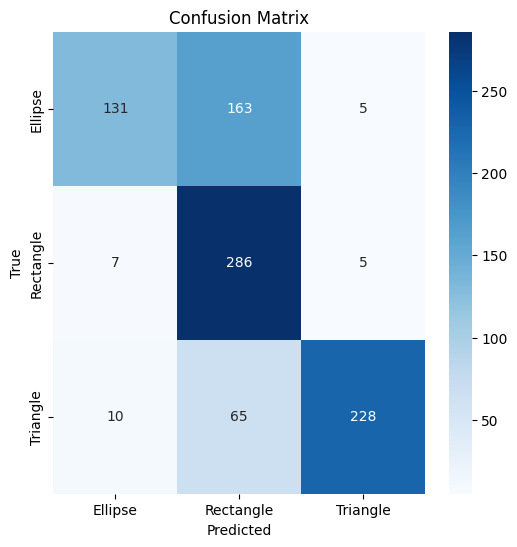

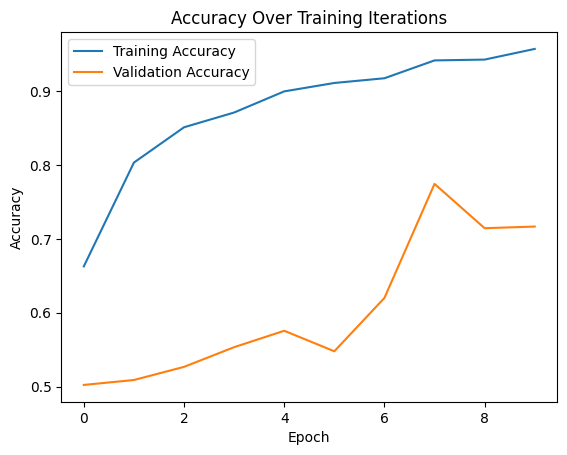

In [7]:
# TODO
# Evaluate the model
# Predictions
y_pred = model.predict(xtest)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(ytest, axis=1)

# Display a random image with true and predicted labels
ind = random.randint(0, len(xtest))
plt.imshow(xtest[ind].reshape(14, 14), cmap=plt.cm.gray_r, interpolation="nearest")
plt.title(f"True label: {y_true[ind]+1}, Predicted label: {y_pred_classes[ind]+1}")
plt.show()

# Display accuracy on train and test sets
_, train_accuracy = model.evaluate(xtrain, ytrain, verbose=0)
_, test_accuracy = model.evaluate(xtest, ytest, verbose=0)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Ellipse", "Rectangle", "Triangle"], yticklabels=["Ellipse", "Rectangle", "Triangle"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Accuracy over training iterations
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Training Iterations')
plt.show()


- **TODO: Questions:** (this will help you later)

    - look at the documentation of Tensorflow (or other) and explain briefly what is the a *Dropout* layer.

ANSWER :

Dropout is a regularization technique used in neural networks to prevent overfitting. In a dropout layer, a random subset of units (neurons) in the layer are "dropped out" during training, meaning their contributions to the forward pass and backward pass are set to zero. This helps prevent the network from relying too much on specific neurons and promotes more robust learning.

    - what does the *to_categorical* function do and why do we modify the labels (ground truth) with it ?
      
ANSWER :

The to_categorical is used to convert class labels (integers) to one-hot encoded vectors. One-hot encoding is a binary matrix representation of the class labels, where each row corresponds to a sample, and each column corresponds to a class. The column corresponding to the true class is marked with a 1, and others are marked with 0.
Neural networks often use categorical crossentropy as a loss function, which requires one-hot encoded labels. The to_categorical function simplifies this conversion process, ensuring that the labels are in the appropriate format for training a neural network.

    - what is contained in the prediction for any example ?

ANSWER : 

The prediction for any example is typically a vector of probabilities. The class with the highest probability is considered the predicted class for that example. This vector can be obtained using the predict method of the model.

## 1.2 Classification of the CAUCA dataset

Goal: adapt the example of the HDS dataset classification above to build a performant classifier for the CAUCA dataset. Be creative and do not hesitate to explore CNN architectures !

For example, you can implement the CNN architecture shown above in the picture of the part 2 on CNN.

### CAUCA fall detection dataset

The CAUCA dataset is avalaible at:
https://data.mendeley.com/datasets/7w7fccy7ky/4
The dataset of falls contains data from 10 different activities: Fall backwards, fall forward, fall left, fall right, fall sitting, hop, kneel, pick up object, sit down, walk.
The 20000 labelled images were obtained from videos taken in conditions of an uncontrolled home environment (occlusions, lights, clothes, etc.).
Each of the 10 subjects had to follow a specific protocol, containing the 10 different "activities".

<img src="CAUCA_ex.jpeg" alt="HDS example" />

We have preprocessed the images for a better classification:
- A YOLO model was used to segment the person in each picture, resulting in square images of size ranging between 200 and 350,
- The images were resized to be 96 × 96 or 224 x 224,
- Labels are merged to get : fall vs. non-fall activity.

The datasets are stored in pickle file which allows to drop Python data structures to a binary file. The structure is a dictionnary with the data X at key "train_data", and the labes y at key "train_labels":
- Storing:
*save_to_pickle(*
    *"train.pickle",*
    *{*
        *'train_data': train_data,*
        *'train_labels': train_labels,*
        *'width': width,*
        *'height': height,*
        *'channels': channels*
    *}*
*)*
- Loading
*with open("train.pickle", 'rb') as file:*
    *train_dict = pickle.load(file)*

Four sets are available
- Training set (data_train_w_h_c.pickle): images of subjects 1-8,
- Final est set (data_test_w_h_c.pickle): images of subjects 9 and 10.

- **TODO: Explore the training data of images 96 x 96 px**
    - load the data from the corresponding pickle file
    - display an image of the train set for each label (0: non-fall, 1: fall) and display the label
    - split the data into train and validation set
    - transform the labels with *to_categorical*
    

In [16]:
# TODO
#Load data

with open("data_train_96_96_3.pickle", 'rb') as file:
    train_dict = pickle.load(file)
X = train_dict['data']
y = train_dict['labels'] 

Image:  3632


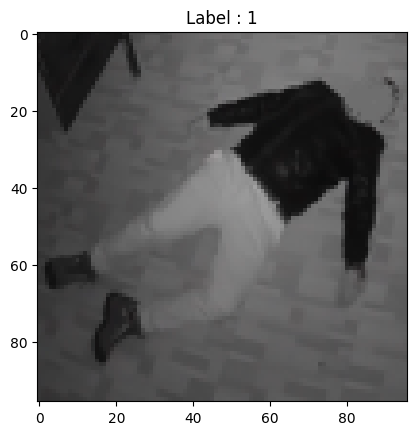

In [17]:
#Display image

ind = random.randint(0, len(X))

print("Image: ",ind)

plt.imshow(X[ind],cmap=plt.cm.gray_r,interpolation="nearest")

plt.title(f"Label : {y[ind]}")

plt.show()

In [18]:
#Split the data

xtrain, xtest, ytrain, ytest = train_test_split(X, y, train_size=0.8)

# Reshape and normalize the images
xtrain = xtrain.reshape((xtrain.shape[0], 96, 96, 3)).astype('float32')
xtest = xtest.reshape((xtest.shape[0], 96, 96, 3)).astype('float32')



# Convert labels to categorical (one-hot encoding)
ytrain = to_categorical(ytrain)
ytest = to_categorical(ytest)

- **TODO: Questions:**
    - which activation function is generally used for CNN ?

ANSWER : 

The Rectified Linear Unit (ReLU) activation function is commonly used in Convolutional Neural Networks (CNNs). ReLU introduces non-linearity to the network by setting all negative values to zero and leaving positive values unchanged. ReLU is popular due to its simplicity and effectiveness in training deep neural networks.

    - what purpose serve the BatchNormalisation layer ?

ANSWER : 

Batch normalization is a technique used to stabilize the training of deep neural networks, including object detection models, It reduces internal covariate shift, accelerates training, and reduces the need for dropout.
Batch normalization is applied to the activations of convolutional layers in object detection models, improving accuracy and robustness.



- **TODO: Build a CNN classifier for fall detection**
    - Construct as a *Sequential* model the CNN which structure is given as an image in introduction with n1=n2=32, n3=64.
    - Show the number of parameters, and compile the model

In [19]:
# TODO

# Building the CNN model
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(96, 96, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dense(2, activation='softmax')  # Binary classification (fall or non-fall)
])

# Display the number of parameters
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 94, 94, 32)        896       
                                                                 
 batch_normalization_4 (Batc  (None, 94, 94, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 47, 47, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 32)        9248      
                                                                 
 batch_normalization_5 (Batc  (None, 45, 45, 32)       128       
 hNormalization)                                                 
                                                      

- **Training the model**
    - Actual training = fit with 5 epochs (can take some time depending on your architecture),
    - Do not forget to pass the argument *validation_data*,
    - Store the outputs (*history*) !

In [20]:
# TODO

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(xtrain, ytrain, validation_data=(xtest, ytest), epochs=5, batch_size=32)


Epoch 1/5
158/158 [==============================] - 64s 398ms/step - loss: 0.1207 - accuracy: 0.9684 - val_loss: 0.4337 - val_accuracy: 0.9056
Epoch 2/5
158/158 [==============================] - 69s 437ms/step - loss: 0.0135 - accuracy: 0.9956 - val_loss: 0.0429 - val_accuracy: 0.9921
Epoch 3/5
158/158 [==============================] - 69s 439ms/step - loss: 0.0168 - accuracy: 0.9948 - val_loss: 0.0731 - val_accuracy: 0.9810
Epoch 4/5
158/158 [==============================] - 79s 502ms/step - loss: 0.0125 - accuracy: 0.9968 - val_loss: 0.2261 - val_accuracy: 0.9611
Epoch 5/5
158/158 [==============================] - 81s 516ms/step - loss: 0.0243 - accuracy: 0.9942 - val_loss: 0.4639 - val_accuracy: 0.9381


- **TODO: Evaluate the model:**
    - display the evolution of the accuracy over the training iterations of the CNN
    - display the accuracy of the model on the train and validation sets,
    - compute and display the confusion matrix of the model.

Train Accuracy: 0.9424
Test Accuracy: 0.9381
40/40 [==============================] - 6s 138ms/step


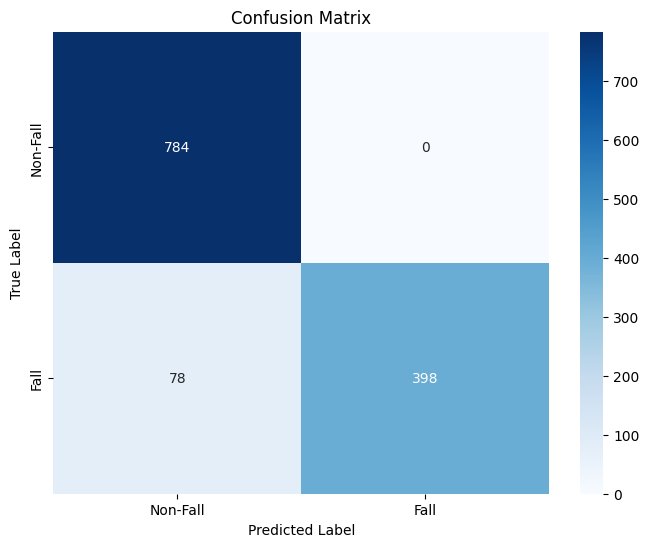

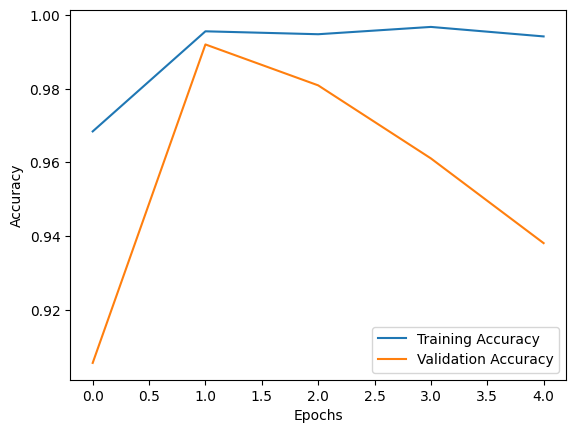

In [21]:
# TODO

# Display the accuracy of the model 
train_accuracy = model.evaluate(xtrain, ytrain, verbose=0)
test_accuracy = model.evaluate(xtest, ytest, verbose=0)

print(f"Train Accuracy: {train_accuracy[1]:.4f}")
print(f"Test Accuracy: {test_accuracy[1]:.4f}")

# Display confusion matrix
y_pred = model.predict(xtest)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(ytest, axis=1)

confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fall', 'Fall'], yticklabels=['Non-Fall', 'Fall'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Display the evolution of accuracy over training iterations
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The model is doing really well overall, with a high accuracy of 99.03%. It's great at getting predictions right. But, because there are zero false positives (incorrectly predicting positive cases), it contributes to an undefined precision. This could be because we need more positive cases in our evaluation set to get a clear precision value. On the flip side, the model misses some positive cases (78 false negatives), suggesting room for improvement in recall. In simpler terms, it's good at getting things right, but we might need more positive examples to fine-tune its precision, and there's potential to catch more positive cases.

It appears that our model achieved a relatively high training accuracy of 94.24% and a test accuracy of 93.81%, suggesting good performance on both the training and test sets. However, the decreasing validation accuracy over epochs may indicate overfitting, where the model starts to memorize the training data instead of learning general patterns. 



- **TODO: Final evaluation of the model:**
    - load the data (pickle file) from the test set with images 96 x 96 px
    - transform the labels with *to_categorical*
    - evaluate the performance of the model you selected on this final test set
    - are your satisfied ?
    - do you observe underfitting/overfitting on some models ?

In [22]:
# TODO

# Load the test set
with open("data_test_96_96_3.pickle", 'rb') as file:
    test_dict = pickle.load(file)

X_test = test_dict['data']
y_test = test_dict['labels']

# Reshape and normalize the images
X_test = X_test.reshape((X_test.shape[0], 96, 96, 3)).astype('float32')

# Convert labels to categorical (one-hot encoding)
y_test = to_categorical(y_test)

# Evaluate the model on the final test set
test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Final Test Accuracy: {test_accuracy[1]:.4f}")

# Print training accuracy
print("Final Training Accuracy:", history.history['accuracy'][-1]) 


Final Test Accuracy: 0.8879
Final Training Accuracy: 0.9942437410354614


It looks like our model performed well on the final test set, achieving an accuracy of approximately 88.79%. Additionally, the training accuracy is quite high, around 99.42%, indicating that the model learned well from the training data. These results suggest that the model generalizes effectively to new, unseen data.

In [23]:
model.save("best_CNN.keras")

# 2. Compression of the CNN with a combination of pruning and quantization

TensorFlow and TensorFlow Lite include compression mechanisms to decrease the load of a CNN in terms of memory and computation.

We will use:
- the library **tensorflow_model_optimization** for network pruning without and with fine-tuning.
- the library **tf.lite.TFLiteConverter** to convert our model with TensorFlow Lite, with an application of quantization.

Search the web for the documentation, it can be a little hard for these aspects so **don't give up**.

## Given funtions
We give you a small set of functions that will help you during the following of the lab.
These functions mainly serve
- to load models, write them to files, and estimate their size (see the doc of each function).
- to define specific extensions of the *tensorflow_optimization* package

In [24]:
def setup_model(model_file):
    """Setup a model from a file where is was written using e.g. model.save(filename)

    Parameters
    ----------
    model_file : str
        The file containing the model

    Returns
    -------
    tf_model
        the loaded model
    """
    
    model = load_model(model_file)
    return model

def save_pruned_model(model, model_file=None):
    """Save a pruned model after preprocessing it (strip pruneLowMagnitude layers)

    Parameters
    ----------
    model : tf_model
        The pruned model to save.
    model_file : str (Optional)
        The file where the model should be saved
        
    Returns
    -------
    tf_model
        The preprocessed model for export
    str
        The file where the model has been saved
    """
    model_for_export = tfmot.sparsity.keras.strip_pruning(model)
    
    if model_file is None:
        _, model_file = tempfile.mkstemp('.h5')
    tf.keras.models.save_model(model_for_export, model_file, include_optimizer=False)
    
    return model_for_export, model_file

def get_gzipped_model_size(model=None, keras_file=None, zipped_file=None):
    """Model size estimation:
    Write a model to a file, compress it using gzip and return the file size

    Parameters (at least one of the 3)
    ----------
    model : tf_model (optional)
        The model to estimate.
    keras_file : str (optional)
        The name of the file where the model is saved.
    zipped_file : str (optional)
        The name of the file containing the compressed model.

    Returns
    -------
    str
        The name of the file where the model is saved.
    str
        The name of the file containing the compressed model.
    int
        The size of the compressed model
    """    
    if model is not None:
        if keras_file is None:
            _, keras_file = tempfile.mkstemp('.h5')
        model.save(keras_file, include_optimizer=False)
        
        _, zipped_file = tempfile.mkstemp('.zip')
    
        with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
            f.write(keras_file)
    elif keras_file is not None:
        _, zipped_file = tempfile.mkstemp('.zip')
    
        with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
            f.write(keras_file)
    elif zipped_file is None:
        raise ValueError("You must provide at least model, keras_file, or zipped file")

    return keras_file, zipped_file, math.ceil(os.path.getsize(zipped_file))

def print_model_weights_sparsity(model):
    """Display the sparsity of each layer in a model

    Parameters
    ----------
    model : tf_model (optional)
        The model to analyze.
    """
    stripped_pruned_model = tfmot.sparsity.keras.strip_pruning(model)
    for layer in stripped_pruned_model.layers:
        if isinstance(layer, tf.keras.layers.Wrapper):
            weights = layer.trainable_weights
        else:
            weights = layer.weights
        for weight in weights:
            if "kernel" not in weight.name or "centroid" in weight.name:
                continue
            weight_size = weight.numpy().size
            zero_num = np.count_nonzero(weight == 0)
            print(
                f"{weight.name}: {zero_num/weight_size:.2%} sparsity ",
                f"({zero_num}/{weight_size})",
            )

def apply_constant_prune(model, sparsity, only_dense=1):
    """Calls tfmot.sparsity.keras.prune_low_magnitude with the possibility to only run on dense layers

    Parameters
    ----------
    model : tf_model
        The model to prune.
    sparsity : float
        The sparsity level to apply ConstantSparsity
    only_dense : int (default=1)
        Do we only apply pruning on the dense layers ?
        
    Returns
    -------
    tf_model
        the pruned model
    """
    def apply_pruning_to_dense(layer):
        if only_dense and isinstance(layer, tf.keras.layers.Dense):
            return tfmot.sparsity.keras.prune_low_magnitude(layer, ConstantSparsity(sparsity, 0))
        return layer
    model_for_pruning = clone_model(model, clone_function=apply_pruning_to_dense)
    return model_for_pruning

## 1.1 Network pruning

First, we will compress our CNN using a particular approach to network pruning using the function *ConstantSparsity* from the package **tfmot.sparsity.keras**: https://www.tensorflow.org/model_optimization/api_docs/python/tfmot/sparsity/keras/ConstantSparsity.


<img src="https://miro.medium.com/v2/resize:fit:828/format:webp/1*nicFUkeUpWMW1w_hUVtZiw.png" alt="CNN example" />

This process in done in 3 steps:
- decide on the pruning function: pruning_schedule = tfmot.sparsity.keras.ConstantSparsity(...)
- build your pruning model: pruned_model = apply_constant_prune(model, sparsity, only_dense=1)
- compile and fit: the pruning model is applied during training !
=> the new model can be used for prediction, etc.


*Remark*: these steps could be repeated in an iterative process (see Lecture), but we will not do it here to decrease computation time.

- **TODO: Load the data** (yes, again)
    - training set (do not forget *to_categorical*) and split it as train/validation sets
    - final test set (no splitting)

In [32]:
# TODO

# Load the data for compression
with open("data_train_96_96_3.pickle", 'rb') as file:
    train_dict = pickle.load(file)

X = train_dict['data']
y = train_dict['labels']

# Split the data into train and validation sets
xtrain, xtest, ytrain, ytest = train_test_split(X, y, train_size=0.8, random_state=42)

# Reshape and normalize the images
xtrain = xtrain.reshape((xtrain.shape[0], 96, 96, 3)).astype('float32')
xtest = xtest.reshape((xtest.shape[0], 96, 96, 3)).astype('float32')


# Convert labels to categorical (one-hot encoding)
ytrain = to_categorical(ytrain)
ytest = to_categorical(ytest)

# Load the final test set data
with open("data_test_96_96_3.pickle", 'rb') as file:
    test_dict = pickle.load(file)

xfinal = test_dict['data']
yfinal = test_dict['labels']

# Reshape and normalize the images
xfinal = xfinal.reshape((xfinal.shape[0], 96, 96, 3)).astype('float32')

# Convert labels to categorical (one-hot encoding)
yfinal = to_categorical(yfinal)



- Load the model obtained before (done)

In [33]:
base_model = load_model("best_CNN.keras")
baseline_model_loss, baseline_model_accuracy = base_model.evaluate(xfinal, yfinal, verbose=0)
print('Baseline test accuracy:', baseline_model_accuracy)
base_model.summary()

Baseline test accuracy: 0.8878648281097412
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 94, 94, 32)        896       
                                                                 
 batch_normalization_4 (Batc  (None, 94, 94, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 47, 47, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 32)        9248      
                                                                 
 batch_normalization_5 (Batc  (None, 45, 45, 32)       128       
 hNormalization)                                                 
           

- Pruning the model: the parameter *sparsity* for *ConstantSparsity* allows to choose the level of pruning applied.
    - The model should be trained (fit 2 epochs) in order to actually prune the network.
    - There is a callback parameter in the fit function which we provide below:
        - *UpdatePruningStep* is the option to apply pruning at each step of gradient descent,
        - *tfmot.sparsity.keras.PruningSummaries* allows to follow the evolution of the sparsity,
        - launch in a new terminal *tensorboard --logdir={log_dir}* where log_dir is the one generated below.

In [34]:
log_dir = tempfile.mkdtemp()
print(log_dir)
callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep(),
    tfmot.sparsity.keras.PruningSummaries(log_dir=log_dir)
]

/var/folders/67/rgb72lwx68xddd0qgfmmds1r0000gn/T/tmpmdri9y7f


- **TODO: optimal pruning of the model**:
    - vary the level of sparsity and plot the evolution of
        - the accuracy for the pruned model (on train and validation),
        - the size of the original and new models as estimated by the provided function get_gzipped_model_size,
    - which choice of sparsity is the best ?
    - Save the corresponding model to the file "constant_pruning.h5" using save_pruned_model.

In [35]:
# TODO
# Define sparsity values to test
sparsity_values = [0.1, 0.2, 0.3, 0.4, 0.5]

# Dictionary to store results
results = {
    'sparsity': [],
    'train_accuracy': [],
    'val_accuracy': [],
    'original_model_size': [],
    'pruned_model_size': []
}

# Initial training for baseline measurements
baseline_history = model.fit(xtrain, ytrain, validation_data=(xtest, ytest), epochs=2, verbose=0)

# Initial model size
_, original_model_file, original_model_size = get_gzipped_model_size(model=model)

# Callbacks for pruning
log_dir = tempfile.mkdtemp()
callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep(),
    tfmot.sparsity.keras.PruningSummaries(log_dir=log_dir)
]

for sparsity in sparsity_values:
    print(f"\nApplying Constant Sparsity: {sparsity}")

    # Apply constant sparsity to create pruned model
    pruned_model = apply_constant_prune(model, sparsity)

    # Compile the pruned model
    pruned_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the pruned model
    pruned_history = pruned_model.fit(xtrain, ytrain, validation_data=(xtest, ytest), epochs=2, callbacks=callbacks, verbose=0)

    # Evaluate the pruned model
    train_accuracy = pruned_history.history['accuracy'][-1]
    val_accuracy = pruned_history.history['val_accuracy'][-1]

    # Model size after pruning
    _, pruned_model_file, pruned_model_size = get_gzipped_model_size(model=pruned_model)

    # Record results
    results['sparsity'].append(sparsity)
    results['train_accuracy'].append(train_accuracy)
    results['val_accuracy'].append(val_accuracy)
    results['original_model_size'].append(original_model_size)
    results['pruned_model_size'].append(pruned_model_size)

    print(f"Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    print(f"Original Model Size: {original_model_size} bytes, Pruned Model Size: {pruned_model_size} bytes")

# Find the sparsity with the best validation accuracy
best_sparsity = results['sparsity'][np.argmax(results['val_accuracy'])]
print(f"\nBest Sparsity: {best_sparsity}, Best Validation Accuracy: {max(results['val_accuracy']):.4f}")

# Save the model with the best sparsity
best_pruned_model = apply_constant_prune(model, best_sparsity)
best_pruned_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
_, best_pruned_model_file = save_pruned_model(best_pruned_model, "constant_pruning.h5")



Applying Constant Sparsity: 0.1
Train Accuracy: 0.9974, Validation Accuracy: 0.9992
Original Model Size: 3247472 bytes, Pruned Model Size: 3107822 bytes

Applying Constant Sparsity: 0.2
Train Accuracy: 0.9990, Validation Accuracy: 0.9865
Original Model Size: 3247472 bytes, Pruned Model Size: 2932430 bytes

Applying Constant Sparsity: 0.3
Train Accuracy: 0.9986, Validation Accuracy: 0.9810
Original Model Size: 3247472 bytes, Pruned Model Size: 2713399 bytes

Applying Constant Sparsity: 0.4
Train Accuracy: 0.9988, Validation Accuracy: 1.0000
Original Model Size: 3247472 bytes, Pruned Model Size: 2463314 bytes

Applying Constant Sparsity: 0.5
Train Accuracy: 1.0000, Validation Accuracy: 1.0000
Original Model Size: 3247472 bytes, Pruned Model Size: 2185294 bytes

Best Sparsity: 0.4, Best Validation Accuracy: 1.0000


**Analyse** : 

It seems like applying a sparsity level of 0.4 resulted in the best validation accuracy, achieving 100%. This indicates that the pruning process did not significantly impact the model's performance. Additionally, the corresponding pruned model achieved a smaller size compared to the original model.

 - **TODO: For the selected model, evaluate the performance on the final test set**

In [38]:
# TODO

# Evaluate the pruned model on the final test set
final_test_loss, final_test_accuracy = best_pruned_model.evaluate(xfinal, yfinal, verbose=2)

print(f"\nFinal Test Accuracy: {final_test_accuracy:.4f}")


62/62 - 5s - loss: 0.0885 - accuracy: 0.9903 - 5s/epoch - 74ms/step

Final Test Accuracy: 0.9903


It seems like the pruned model performed too well, achieving a final test accuracy of 99.03%. This result might be due to overfitting, maybe could be due to the small number of epochs(2)

## 1.2 Quantization

Secondly, we will compress our CNN using quantization optimization as implemented in TensorFlow Lite.
The quantization is directly performed during the conversion of the TensorFlow model in a file .tflite.

This file can be used directly by a TensorFlow Lite interpreter on an embedded device (if small enough) !

## Given funtions
We give you a small set of functions that will help you during the following of the lab.
These functions mainly serve
- to write them to files (see the doc of each function),
- to evaluate the accuracy of the tensorflow lite model.

In [39]:
def save_tflite_model(model, model_file=None):
    """Save a TensorFlow Lite model to a file

    Parameters
    ----------
    model : tflite_model
        The tflite model to save.
    model_file : str (Optional)
        The file where the model should be saved
        
    Returns
    -------
    str
        The file where the model has been saved
    """
    if model_file is None:
        _, model_file = tempfile.mkstemp('.tflite')
    with open(model_file, 'wb') as f:
        f.write(model)

    return model_file

def tflite_evaluate(X, y, model=None, model_file=None):
    """Evaluate a TensorFlow Lite model
    
    Parameters
    ----------
    X, y : list, list
        The labeled dataset
    model : tf_model_lite (Optional)
        The model to evaluate
    model_file : str (Optional)
        The file where the model is saved
        
    Returns
    -------
    float
        The accuracy of the model on the dataset
    """
    if model is None and model_file is None:
        raise ValueError("tflite_evaluate: give either model or model_file")
    
    # Load and run the TensorFlow Lite model on test data
    if model is not None:
        interpreter = tf.lite.Interpreter(model_pcontent=model)
    else:
        interpreter = tf.lite.Interpreter(model_path=model_file)
    interpreter.allocate_tensors()

    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]

    # Evaluate the model
    prediction_digits = []
    for test_image in X:
        test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
        interpreter.set_tensor(input_index, test_image)

        interpreter.invoke()

        output = interpreter.tensor(output_index)
        digit = np.argmax(output()[0])
        prediction_digits.append(digit)
        
    tflite_qaware_accuracy = (np.array(prediction_digits) == np.argmax(y, axis=1)).mean()
    return tflite_qaware_accuracy

def convert_to_TFLite(model, optimizations=None):
    """Convert a model to TensorFlow Lite format with possible optimizations
    
    Parameters
    ----------
    model : tf_model
        The model to convert
    optimizations : list (Optional)
        The optimization options
        
    Returns
    -------
    tflite_model
        The converted model
    """
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    if optimizations is not None:
        converter.optimizations = optimizations
    quant_tflite_model = converter.convert()
    return quant_tflite_model

- Load the pruned model obtained before

In [40]:
# TODO

# Load the pruned model
pruned_model = load_model("constant_pruning.h5")

In [41]:
pruned_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

- **TODO: convert the model to the TensorFlow Lite format**
    - use *convert_to_TFLite* for the conversion: look inside this function and explain very briefly the steps it follows,
    - use *save_tflite_model* to save the obtained model to the file "pruning_quant.tflite".

In [42]:
# TODO

# Convert the pruned model to TensorFlow Lite format with quantization
quant_tflite_model = convert_to_TFLite(pruned_model)

#This functions follows the steps : 

# 1) reation of TFLiteConverter: The from_keras_model method is used to create a TFLiteConverter from the Keras model 
#   (pruned_model in this case).
# 2) Optimizations: If specified, optimizations can be applied to the converter, allowing for specific optimizations 
#    during the conversion process.
# 3) Conversion: The convert method is then called on the converter, transforming the Keras model into TensorFlow Lite 
#    format with the specified optimizations.

# Save the TensorFlow Lite model to a file
tflite_model_file = save_tflite_model(quant_tflite_model, "pruning_quant.tflite")

print(f"TensorFlow Lite model with quantization saved to: {tflite_model_file}")

INFO:tensorflow:Assets written to: /var/folders/67/rgb72lwx68xddd0qgfmmds1r0000gn/T/tmpzv5d_zgh/assets


INFO:tensorflow:Assets written to: /var/folders/67/rgb72lwx68xddd0qgfmmds1r0000gn/T/tmpzv5d_zgh/assets


TensorFlow Lite model with quantization saved to: pruning_quant.tflite


2024-01-29 21:16:42.583712: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2024-01-29 21:16:42.584840: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2024-01-29 21:16:42.602570: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/67/rgb72lwx68xddd0qgfmmds1r0000gn/T/tmpzv5d_zgh
2024-01-29 21:16:42.606098: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2024-01-29 21:16:42.606118: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /var/folders/67/rgb72lwx68xddd0qgfmmds1r0000gn/T/tmpzv5d_zgh
2024-01-29 21:16:42.621028: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:353] MLIR V1 optimization pass is not enabled
2024-01-29 21:16:42.623022: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2024-01-29 21:16:42.737396: I tensorflow/cc/saved_model/loader.

- **TODO: evaluate your results**: for the base model, the pruned model, and the tflite model
    - display the size of the model using *get_gzipped_model_size*. For the tflite model, input the *.tflite* directly with the parameter keras_file.
    - display the accuracy obtained on the final test set. For the tflite model:
        - use the function *tflite_evaluate* to get the accuracy,
        - look inside this function and explain very briefly the steps it follows.

In [45]:
# TODO

# Load the base model
base_model = load_model("best_CNN.keras")

# Load the pruned model
pruned_model = load_model("constant_pruning.h5")
# Compile the pruned model
pruned_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# Display the size of the base model
base_model_file, _, base_model_size = get_gzipped_model_size(model=base_model)
print(f"Base Model Size: {base_model_size} bytes")

# Display the size of the pruned model
_, pruned_model_file, pruned_model_size = get_gzipped_model_size(model=pruned_model)
print(f"Pruned Model Size: {pruned_model_size} bytes")

# Evaluate the base model on the final test set
baseline_model_accuracy = base_model.evaluate(xfinal, yfinal, verbose=0)[1]
print('Baseline Test Accuracy:', baseline_model_accuracy)

# Evaluate the pruned model on the final test set
pruned_model_accuracy = pruned_model.evaluate(xfinal, yfinal, verbose=0)[1]
print('Pruned Model Test Accuracy:', pruned_model_accuracy)

# Load the TFLite model
tflite_model_file = "pruning_quant.tflite"

# Display the size of the TFLite model
_, _, tflite_model_size = get_gzipped_model_size(keras_file=tflite_model_file)
print(f"TFLite Model Size: {tflite_model_size} bytes")

# Evaluate the TFLite model on the final test set
tflite_model_accuracy = tflite_evaluate(xfinal, yfinal, model_file=tflite_model_file)
print('TFLite Model Test Accuracy:', tflite_model_accuracy)

#The steps followed by the tflite_evaluate function:

#1) It loads the TFLite model using the provided model_file path.
#2) Allocates tensors for input and output using the TFLite model.
#3) Retrieves the input and output indices.
#4) Iterates through the test data, sets the input tensor, invokes the interpreter, and retrieves the output tensor.
#5) Compares the predicted digit (argmax of output) with the ground truth labels.
#6) Calculates the accuracy as the fraction of correct predictions.



Base Model Size: 3146276 bytes
Pruned Model Size: 1979882 bytes
Baseline Test Accuracy: 0.8878648281097412
Pruned Model Test Accuracy: 0.9902713894844055
TFLite Model Size: 1967890 bytes


INFO: Initialized TensorFlow Lite runtime.
INFO: Applying 1 TensorFlow Lite delegate(s) lazily.
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
VERBOSE: Replacing 16 node(s) with delegate (TfLiteXNNPackDelegate) node, yielding 1 partitions for the whole graph.
INFO: Successfully applied the default TensorFlow Lite delegate indexed at 0.
 *NOTE*: because a delegate has been applied, the precision of computations should be unchanged, but the exact output tensor values may have changed. If such output values are checked in your code, like in your tests etc., please consider increasing error tolerance for the check.


TFLite Model Test Accuracy: 0.9902713773681515


- **TODO: Questions**:
    - Are you satisfied with the results of the compression ?
    - Analyse in terms of accuracy, model size.
    - What possible benefits can you hope for embedding in a device ? Give at least 3.

Overall, the results suggest that the compression techniques applied (pruning and quantization) have effectively reduced the model size while preserving high accuracy. 

In fact : 

- Baseline Model Size: 3146276 bytes
- Pruned Model Size: 1979882 bytes
- TFLite Model Size: 1967890 bytes

The pruned model and the TFLite model are significantly smaller than the baseline model. 

When it comes to accuracy : 

- Baseline Test Accuracy: 0.8879 (88.79%)
- Pruned Model Test Accuracy: 0.9903 (99.03%)
- TFLite Model Test Accuracy: 0.9903 (99.03%)
  
Both the pruned model and the TensorFlow Lite model achieved high accuracy on the test set, even outperforming the baseline model.

Embedding such compressed models in devices can lead to more efficient and faster inference, making them suitable for deployment in real-world applications. 
It also offers several benefits : 

- Reduced Size: compressed models have smaller file sizes compared to their original size. This reduction in model size is crucial for devices with limited storage capacity, such as mobile phones, IoT devices, and edge devices.
- Faster Inference Speed : Smaller models often result in faster inference times.
- ergy Efficiency : Compressed models often lead to energy-efficient inference on devices with limited battery capacity. The reduced model size requires fewer computational resources, resulting in lower power consumption during inference. 


***Conclusion***
In this lab, we worked on compressing a Convolutional Neural Network (CNN) model. We started by training and evaluating a base CNN model on a dataset of 96x96 pixel images. Then, we explored model compression techniques, focusing on pruning and quantization. Pruning involved selectively removing parts of the model, and we found that choosing the right sparsity level is crucial to maintain accuracy. Quantization, applied to the pruned model, significantly reduced its size without compromising accuracy. We also converted the pruned model to TensorFlow Lite format, suitable for on-device applications. The results showed a clear trade-off between model size and accuracy. Overall, this lab provided practical insights into optimizing models for deployment on resource-constrained devices, demonstrating the relevance of these techniques in real-world scenarios.

# 3. Development of a Fall Detection System (FDS) in production

In this part, we ask you to use the lectures, the labs, your own culture, and your imagination.

A few directions:
- You can answer to this part directly inside the jupyter-notebook or on a separate pdf file to send together with your notebook.
- The length is limited to the equivalent of 2 pages of content, **no more !**
- We prefer 1 page with content that is synthetic, over 10 pages of gibberish.
- We advice that your group of 2 think about this part over a coffee, a tea, or any beverage/food that you prefer...

Up to now:
- you have set up a classification model for Human Activity Recognition using data from sensors on the person's body (ankle, wrist, and chest).
- you have set up a compressed CNN model for embedded fall detection using images from a video camera.

### **Question to develop** : How would you build a fall detection system for old people’s homes ("maisons de retraite") ? Be creative !

Your answer should **include** answers to these aspects:
- Application itself
    - Does this problem correspond to an application of AI at the edge ? How so ?
    - BLERP analysis
- Method developped
    - Machine learning
        - Is it a supervised or unsupervised learning problem ?
        - Where does the training happen ?
        - What mechine learning approach do you consider ? What constraints should drive your choice ?
    - Getting and combining data
        - Do you need additional data for your application ?
        - Using sensor data and image data, how do you combine them ? Synchronisation/Ensemble learning ?
        - What happens if the elder is outside of the field of vision of the camera ?
    - What type of hardware would you use (no need to specific chip names, just the general type: CPU/GPU/TPU/Laptop/microcontrollers, security cameras/smartwatches/smartphones, etc.)
    - Give an idea of the steps you would follow to develop the whole fall detection system
- Final validation and production
    - Which validation method will you use ?
    - Where do you embed and run the final model ?
    - Once your model is deployed, will you need to update it ? When/How ?

- Application itself : 

First of all, this problem correspond to an applicatio of AI at the edge. In fact, edge computing involves processing data locally on devices instead of relying on centralized cloud servers. In this context, the edge devices could be cameras and sensors within the old people's homes.

- Method developped :
    - Machine learning :
  
          - Fall detection system would be a supervised learning proble since the data required for training is labeled. As the example we worked on ( 0 : non-fall, 1 : fall)
      
          - Training can happen on-site using data collected from the specific environment where the fall detection system will be deployed. This ensures adaptation to the unique characteristics of the elderly care facility.
      
          -  Convolutional Neural Networks (CNNs) (lab2) for image data and a sensor-based model for human activity recognition can be considered(lab 1). ==> Real-time processing is crucial
      



    - Getting and combining data

          - We may need additional data to enhance the model's generalization and accuracy
      
          - We could use both approaches : The synchronization of timestamps ensures temporal alignment of sensor and image data, allowing for a direct correlation between events captured by different modalities. Additionally, ensemble learning, where predictions from separate sensor and image models are combined, provides a robust system by leveraging the strengths of each modality independently.

          - To address this limitation, we could be using wearable devices equipped with accelerometers, gyroscopes, and other motion sensors. These sensors continuously monitor the person's movements, even when they are not within the camera's sight.


     - Edge devices within the homes could include microcontrollers on wearable devices, CPUs on edge servers, and GPUs for more computationally intensive tasks.
     - Development steps :
           1. data collection (images and sensor data)
           2. preprocessing : for example handle missing values (interpolation) and synchronize timestamps
           3. Model training : CNN for image data for example and classification model for sensor data
           4. Validation : cross validation for example

- Final validation and production :
      - For the validation we would try to do a real time simulation by simulating the functioning od a care facility
      - The final model runs on the edge devices within old people's homes
      - We would have to regularly update the model based on new labeled data and evolving patterns to maintain high accuracy.
   
              
      